# Convolutional Nerual Network #
This Jypternotebook is dedicated to the creation of a Machine Learning algorithm for Convolutional Nerual Networks.
The data set that will be used is the MNIST handwritten numbers. Very helpful resource: https://www.kaggle.com/code/milan400/cnn-from-scratch-numpy

# CNN Architecture #

Input = Image
- Conv: Convolution of two matrices $C[i, j] = ∑(k=0 to M-1) ∑(l=0 to N-1) A[i-k, j-l] * B[k, l] $
- Max Pooling: Max pooling is a pooling operation that selects the maximum element from the region of the feature map covered by the filter.
- Softmax : $\sigma(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K$
- Derative: $(f(x+h) - f(x)) \over h$


In [1]:
# Library Imports
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Importing the MNIST Data set
dataOrgTrain = pd.read_csv("datasets/mnist_train.csv")
dataOrgTest = pd.read_csv("datasets/mnist_test.csv")

# Seperating the Labels from the training and testing set
train_labels = dataOrgTrain["label"]
train_images = dataOrgTrain.drop('label', axis=1)

test_labels = dataOrgTest["label"]
test_images = dataOrgTest.drop('label', axis=1)

print("There are ",dataOrgTest.shape," labels in the train set")
print("There are ",dataOrgTrain.shape," labels in the test set")

There are  (10000, 785)  labels in the train set
There are  (60000, 785)  labels in the test set


In [4]:
# Converting each row into a matrix and then placing those matrices into a stack
matrixSize =  np.sqrt(dataOrgTrain.shape[1])

train_images_arr = np.array(train_images)
train_images_stack = train_images_arr.reshape((len(train_images_arr), matrixSize, matrixSize))

test_images_arr = np.array(test_images)
test_images_stack = test_images_arr.reshape((len(test_images_arr), matrixSize, matrixSize))

print("The training set stack shape is: ", train_images_stack.shape)
print("The testing set stack shape is: ", test_images_stack.shape)

The training set stack shape is:  (60000, 28, 28)
The testing set stack shape is:  (10000, 28, 28)


In [6]:
# Automatically get the Classifications names
classNames = list(set(train_labels))
print(classNames)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Size of data set: (60000, 28, 28)
Image size: 5 x 5

 First 10 images of train set:


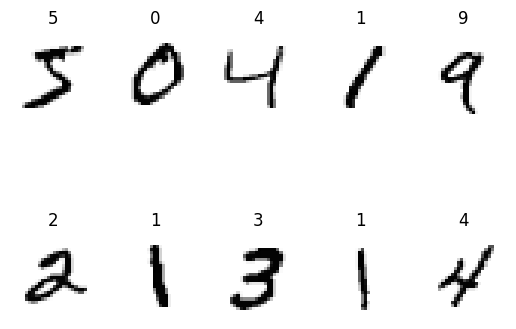

In [7]:
from matplotlib.pyplot import gray

print("Size of data set: " + str(train_images_stack.shape))
imageDimension = int((train_images_stack.shape[1] - 1) ** 0.5)
print("Image size: " + str(imageDimension) + " x " + str(imageDimension))

# Plotting the Data
print("\n First 10 images of train set:")
for i in range(10): # plotting 10 images of data set
  plt.subplot(2,5,i+1) # 2 rows with 5 columns
  plt.imshow(train_images_stack[i],cmap='Greys')
  plt.title(f"{classNames[train_labels[i]]}")
  plt.axis('off')
plt.show()



In [8]:
class Conv:
    
    def __init__(self, num_filters):
        self.num_filters = num_filters
        
        #why divide by 9...Xavier initialization
        self.filters = np.random.randn(num_filters, 3, 3)/9
    
    def iterate_regions(self, image):
        #generates all possible 3*3 image regions using valid padding
        
        h,w = image.shape
        
        for i in range(h-2):
            for j in range(w-2):
                im_region = image[i:(i+3), j:(j+3)]
                yield im_region, i, j
                
    def forward(self, input):
        self.last_input = input
        
        h,w = input.shape
        
        output = np.zeros((h-2, w-2, self.num_filters))
        
        for im_regions, i, j in self.iterate_regions(input):
            output[i, j] = np.sum(im_regions * self.filters, axis=(1,2))
        return output
    
    def backprop(self, d_l_d_out, learn_rate):
        '''
        Performs a backward pass of the conv layer.
        - d_L_d_out is the loss gradient for this layer's outputs.
        - learn_rate is a float.
        '''
        d_l_d_filters = np.zeros(self.filters.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                d_l_d_filters[f] += d_l_d_out[i,j,f] * im_region

        #update filters
        self.filters -= learn_rate * d_l_d_filters

        return None    

In [9]:
# Backpropagation
class MaxPool:
    
    def iterate_regions(self, image):
        h, w, _ = image.shape
        
        new_h = h // 2
        new_w = w // 2
        
        for i in range(new_h):
            for j in range(new_w):
                im_region = image[(i*2):(i*2+2), (j*2):(j*2+2)]
                yield im_region, i, j
                
    def forward(self, input):
        
        self.last_input = input
        
        h, w, num_filters = input.shape
        output = np.zeros((h//2, w//2, num_filters))
        
        for im_region, i, j in self.iterate_regions(input):
            output[i,j] = np.amax(im_region,axis=(0,1))
            
        return output
    
    def backprop(self, d_l_d_out):
        '''
        Performs a backward pass of the maxpool layer.
        Returns the loss gradient for this layer's inputs.
        - d_L_d_out is the loss gradient for this layer's outputs.
        '''
        d_l_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0,1))

            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        #if the pixel was the max value, copy the gradient to it
                        if(im_region[i2,j2,f2] == amax[f2]):
                            d_l_d_input[i*2+i2, j*2+j2 ,f2] = d_l_d_out[i, j, f2]
                            break;
        return d_l_d_input

In [10]:
# Backpropagation
class Softmax:
    
    def __init__(self, input_len, nodes):
        # We divide by input_len to reduce the variance of our initial values
        self.weights = np.random.randn(input_len, nodes)/input_len
        self.biases = np.zeros(nodes)
    
    def forward(self, input):
        
        self.last_input_shape = input.shape
        
        input = input.flatten()
        self.last_input = input
        
        input_len, nodes = self.weights.shape
        
        totals = np.dot(input, self.weights) + self.biases
        self.last_totals = totals
        
        exp = np.exp(totals)
        return(exp/np.sum(exp, axis=0)) 
    
    def backprop(self, d_l_d_out, learn_rate):
        """  
        Performs a backward pass of the softmax layer.
        Returns the loss gradient for this layers inputs.
        - d_L_d_out is the loss gradient for this layers outputs.
        """
        
        #We know only 1 element of d_l_d_out will be nonzero
        for i, gradient in enumerate(d_l_d_out):
            if(gradient == 0):
                continue
            
            #e^totals
            t_exp = np.exp(self.last_totals)
            
            #Sum of all e^totals
            S = np.sum(t_exp)
            
            #gradients of out[i] against totals
            d_out_d_t = -t_exp[i] * t_exp/ (S**2)
            d_out_d_t[i] = t_exp[i] * (S-t_exp[i]) /(S**2)
            
            # Gradients of totals against weights/biases/input
            d_t_d_w = self.last_input
            d_t_d_b = 1
            d_t_d_inputs = self.weights
            
            #Gradients of loss against totals
            d_l_d_t = gradient * d_out_d_t
            
            #Gradients of loss against weights/biases/input
            d_l_d_w = d_t_d_w[np.newaxis].T @ d_l_d_t[np.newaxis]
            d_l_d_b = d_l_d_t * d_t_d_b  
            d_l_d_inputs = d_t_d_inputs @ d_l_d_t
            
            #update weights/biases
            self.weights -= learn_rate * d_l_d_w
            self.biases -= learn_rate * d_l_d_b
            return d_l_d_inputs.reshape(self.last_input_shape)

In [11]:
# Convolutional Neural Network model implmentation
class CNN:
    
    def __init__(self, num_filters, input_len, nodes):
        self.num_filters = num_filters
        self.conv = Conv(num_filters)
        self.pool = MaxPool()
        self.softmax = Softmax(input_len, nodes)               

    def forward(self, image, label):
        # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
        # to work with. This is standard practice.
        
        out = self.conv.forward((image/255) - 0.5)
        out = self.pool.forward(out)
        out = self.softmax.forward(out)
        
        #calculate cross-entropy loss and accuracy
        loss = -np.log(out[label])
        acc = 1 if(np.argmax(out) == label) else 0
        
        return out, loss, acc

    def train(self, im, label, lr=0.005):
        #forward
        out,loss,acc = self.forward(im, label)
        
        #calculate initial gradient
        gradient = np.zeros(10)
        gradient[label] = -1/out[label]
        
        #Backprop
        gradient = self.softmax.backprop(gradient, lr)
        gradient = self.pool.backprop(gradient)
        gradient = self.conv.backprop(gradient, lr)
        
        return loss, acc
    
    def predict(self, image):
        # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
        # to work with. This is standard practice.
        
        out = self.conv.forward((image/255) - 0.5)
        out = self.pool.forward(out)
        out = self.softmax.forward(out)

        max_index = np.argmax(out)

        return classNames[max_index]

In [ ]:
# Creating an Instance of the machine Learning Mode
numLayers = 8
inputLen = 13 * 13 * 8
nodes = 10

ModelCNN = CNN(numLayers, inputLen, nodes)

In [12]:
print('MNIST CNN initialized')
train_images = train_images_stack.copy()

for epoch in range(2):
    print('----EPOCH %d ---'%(epoch+1))
    
    #shuffle the training data
    permutation = np.random.permutation(len(train_images))
    train_images = train_images[permutation]
    train_labels = train_labels[permutation]


    loss = 0
    num_correct = 0

    for i, (im, label) in enumerate(zip(train_images, train_labels)):

        #print stats every 100 steps
        if(i>0 and i %100 == 99):
            print('[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %(i + 1, loss / 100, num_correct))

            loss = 0
            num_correct = 0
          
        l, acc = ModelCNN.train(im, label)
        loss += l
        num_correct += acc

MNIST CNN initialized
----EPOCH 1 ---
[Step 100] Past 100 steps: Average Loss 2.258 | Accuracy: 15%
[Step 200] Past 100 steps: Average Loss 2.154 | Accuracy: 32%
[Step 300] Past 100 steps: Average Loss 2.036 | Accuracy: 37%
[Step 400] Past 100 steps: Average Loss 1.898 | Accuracy: 47%
[Step 500] Past 100 steps: Average Loss 1.635 | Accuracy: 60%
[Step 600] Past 100 steps: Average Loss 1.343 | Accuracy: 68%
[Step 700] Past 100 steps: Average Loss 1.070 | Accuracy: 74%
[Step 800] Past 100 steps: Average Loss 0.964 | Accuracy: 70%
[Step 900] Past 100 steps: Average Loss 0.884 | Accuracy: 77%
[Step 1000] Past 100 steps: Average Loss 0.820 | Accuracy: 78%
[Step 1100] Past 100 steps: Average Loss 0.601 | Accuracy: 79%
[Step 1200] Past 100 steps: Average Loss 0.719 | Accuracy: 75%
[Step 1300] Past 100 steps: Average Loss 0.567 | Accuracy: 85%
[Step 1400] Past 100 steps: Average Loss 0.581 | Accuracy: 82%
[Step 1500] Past 100 steps: Average Loss 0.514 | Accuracy: 86%
[Step 1600] Past 100 steps

KeyboardInterrupt: 

Size of data set: (10000, 28, 28)
Image size: 5 x 5

 First 10 images of train set:


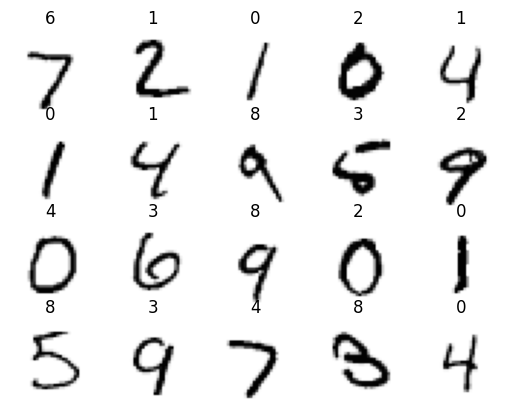

In [ ]:
from matplotlib.pyplot import gray

print("Size of data set: " + str(test_images_stack.shape))
imageDimension = int((test_images_stack.shape[1] - 1) ** 0.5)
print("Image size: " + str(imageDimension) + " x " + str(imageDimension))

# Plotting the Data
print("\n First 10 images of train set:")
for i in range(20): # plotting 10 images of data set
  plt.subplot(4,5,i+1) # 2 rows with 5 columns
  plt.imshow(test_images_stack[i],cmap='Greys')
  plt.title(f"{classNames[ModelCNN.predict(test_images_stack[i])]}")
  plt.axis('off')
plt.show()
